In [1]:
## load packages
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import mapping
from rasterio.mask import mask
import rioxarray
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [2]:
## load data
path_data = '/work/lh88wasu-BA_Portugal/Data/FWI/FWI/'
path_pa = "/home/sc.uni-leipzig.de/lu942pyci/Masterthesis/Data/Portugal_shp/PT_continental.shp"  # Path to Portugal shapefile
path_fig = '/home/sc.uni-leipzig.de/lu942pyci/Masterthesis/Figures/'
pt_shape = gpd.read_file(path_pa)

In [3]:
# Use xarray to open all .nc files in the directory
files = sorted([os.path.join(path_data, f) for f in os.listdir(path_data) if f.endswith(".nc")])

# Load all .nc files into one dataset
ds = xr.open_mfdataset(files, combine="by_coords", chunks={"time": 100})
ds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (valid_time: 7305, latitude: 504, longitude: 324)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 2001-01-01T12:00:00 ... 2020-12-...
  * latitude     (latitude) float64 42.3 42.29 42.28 42.27 ... 36.82 36.81 36.8
  * longitude    (longitude) float64 -9.5 -9.489 -9.478 ... -6.022 -6.011 -6.0
    spatial_ref  int64 0
Data variables:
    t2m_celsius  (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    rh           (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    ws           (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    tp_cum       (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    ffmc         (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    dmc          (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    dc           (valid_time, latitude, longitude) float32 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    isi          (valid_time, latitude, longitude) float64 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    bui          (valid_time, latitude, longitude) float64 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>
    fwi          (valid_time, latitude, longitude) float64 dask.array<chunksize=(365, 504, 324), meta=np.ndarray>

In [4]:
## clip to Portugal shape
data = ds.rio.clip(geometries=pt_shape.geometry.map(mapping), crs=pt_shape.crs, drop=True)

In [5]:
## FWI mean and max over whole Portugal
fwi_mean = data.fwi.mean(dim=["latitude", "longitude"], skipna=True)
fwi_max = data.fwi.max(dim=["latitude", "longitude"], skipna=True)

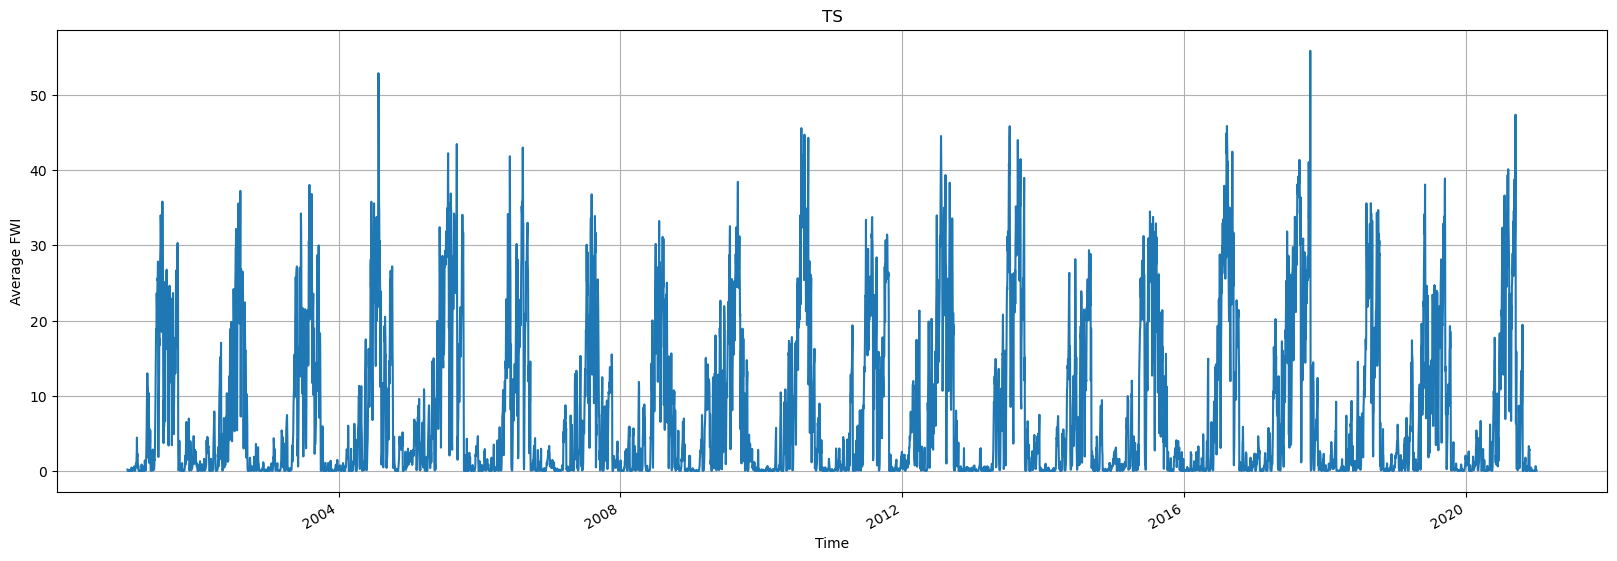

In [6]:
# Plot the timeseries
plt.figure(figsize=(20, 6))
fwi_mean.plot(linestyle='-')  # xarray's built-in plot
plt.title("TS")
plt.xlabel("Time")
plt.ylabel("Average FWI")
plt.grid(True)

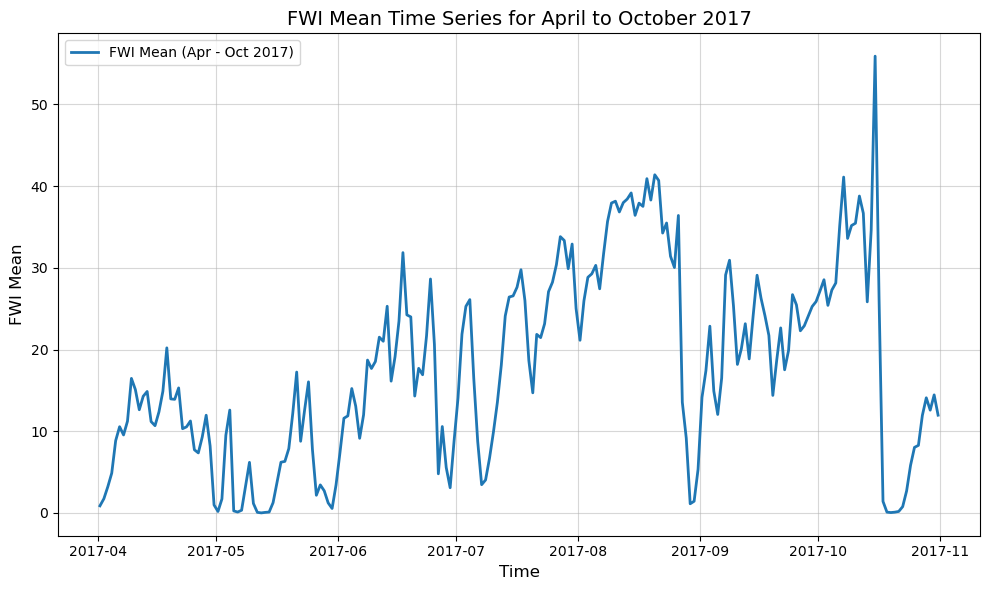

In [7]:
# Select data for the year 2017, from April to end of October, as it is in Ramos to compare the TS
fwi_mean_2017 = fwi_mean.sel(valid_time=slice("2017-04-01", "2017-10-31"))

# Plot the FWI mean time series for 2017
plt.figure(figsize=(10, 6))
plt.plot(fwi_mean_2017['valid_time'], fwi_mean_2017, label='FWI Mean (Apr - Oct 2017)', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Time', fontsize=12)
plt.ylabel('FWI Mean', fontsize=12)
plt.title('FWI Mean Time Series for April to October 2017', fontsize=14)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()

In [ ]:
## Plot map of FWI for Obtober 2017 as an example

In [19]:
oct17 = data.fwi.sel(valid_time=slice("2017-10-01", "2017-10-31"))

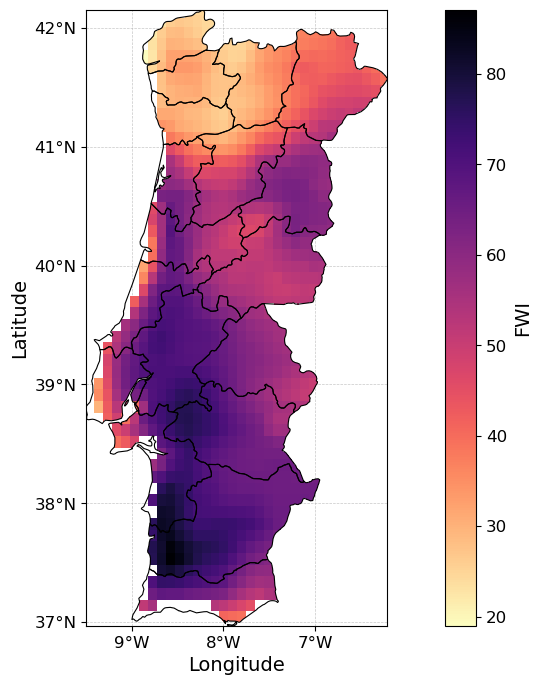

In [14]:
## Plot October 15th (valid time step 14)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Plot specific day
p = oct17.isel(valid_time=14).plot(ax=ax, cmap='magma_r')  # 
# Plot the boundary of the shapefile on top of the raster
pt_shape.boundary.plot(ax=ax, color='black', linewidth=0.8)

p.colorbar.set_label("FWI", fontsize=14)
p.colorbar.ax.tick_params(labelsize=12) 

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('')
ax.tick_params(axis='both', labelsize=12)

# add grid behind the axis tick labels
ax.set_axisbelow(True)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Format tick labels with °N and °W
def format_lat(lat, pos):
    return f"{abs(lat):.0f}°{'N' if lat >= 0 else 'S'}"

def format_lon(lon, pos):
    return f"{abs(lon):.0f}°{'E' if lon >= 0 else 'W'}"

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

plt.savefig(path_fig + 'FWI_map_Oct2017.png', bbox_inches = 'tight', dpi = 250)

In [29]:
max_value = oct17.isel(valid_time=14).max(skipna=True).values
min_value = oct17.isel(valid_time=14).min(skipna=True).values

In [31]:
print(max_value)
print(min_value)

87.11629499608475
18.98178662035081


## Plotting of the FWI components

In [22]:
# List of variables to process
variables = ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]

# Calculate the mean over the spatial dimensions (Portugal region)
mean_data = data[variables].mean(dim=["longitude", "latitude"])

# Ensure time is a datetime-like object
mean_data["valid_time"] = pd.to_datetime(mean_data["valid_time"].values)

# Extract year and day-of-year (doy) for time alignment
mean_data = mean_data.assign_coords(
    year=("valid_time", mean_data["valid_time"].dt.year.data),  # Use .data to extract values
    doy=("valid_time", mean_data["valid_time"].dt.dayofyear.data)  # Use .data here as well
)


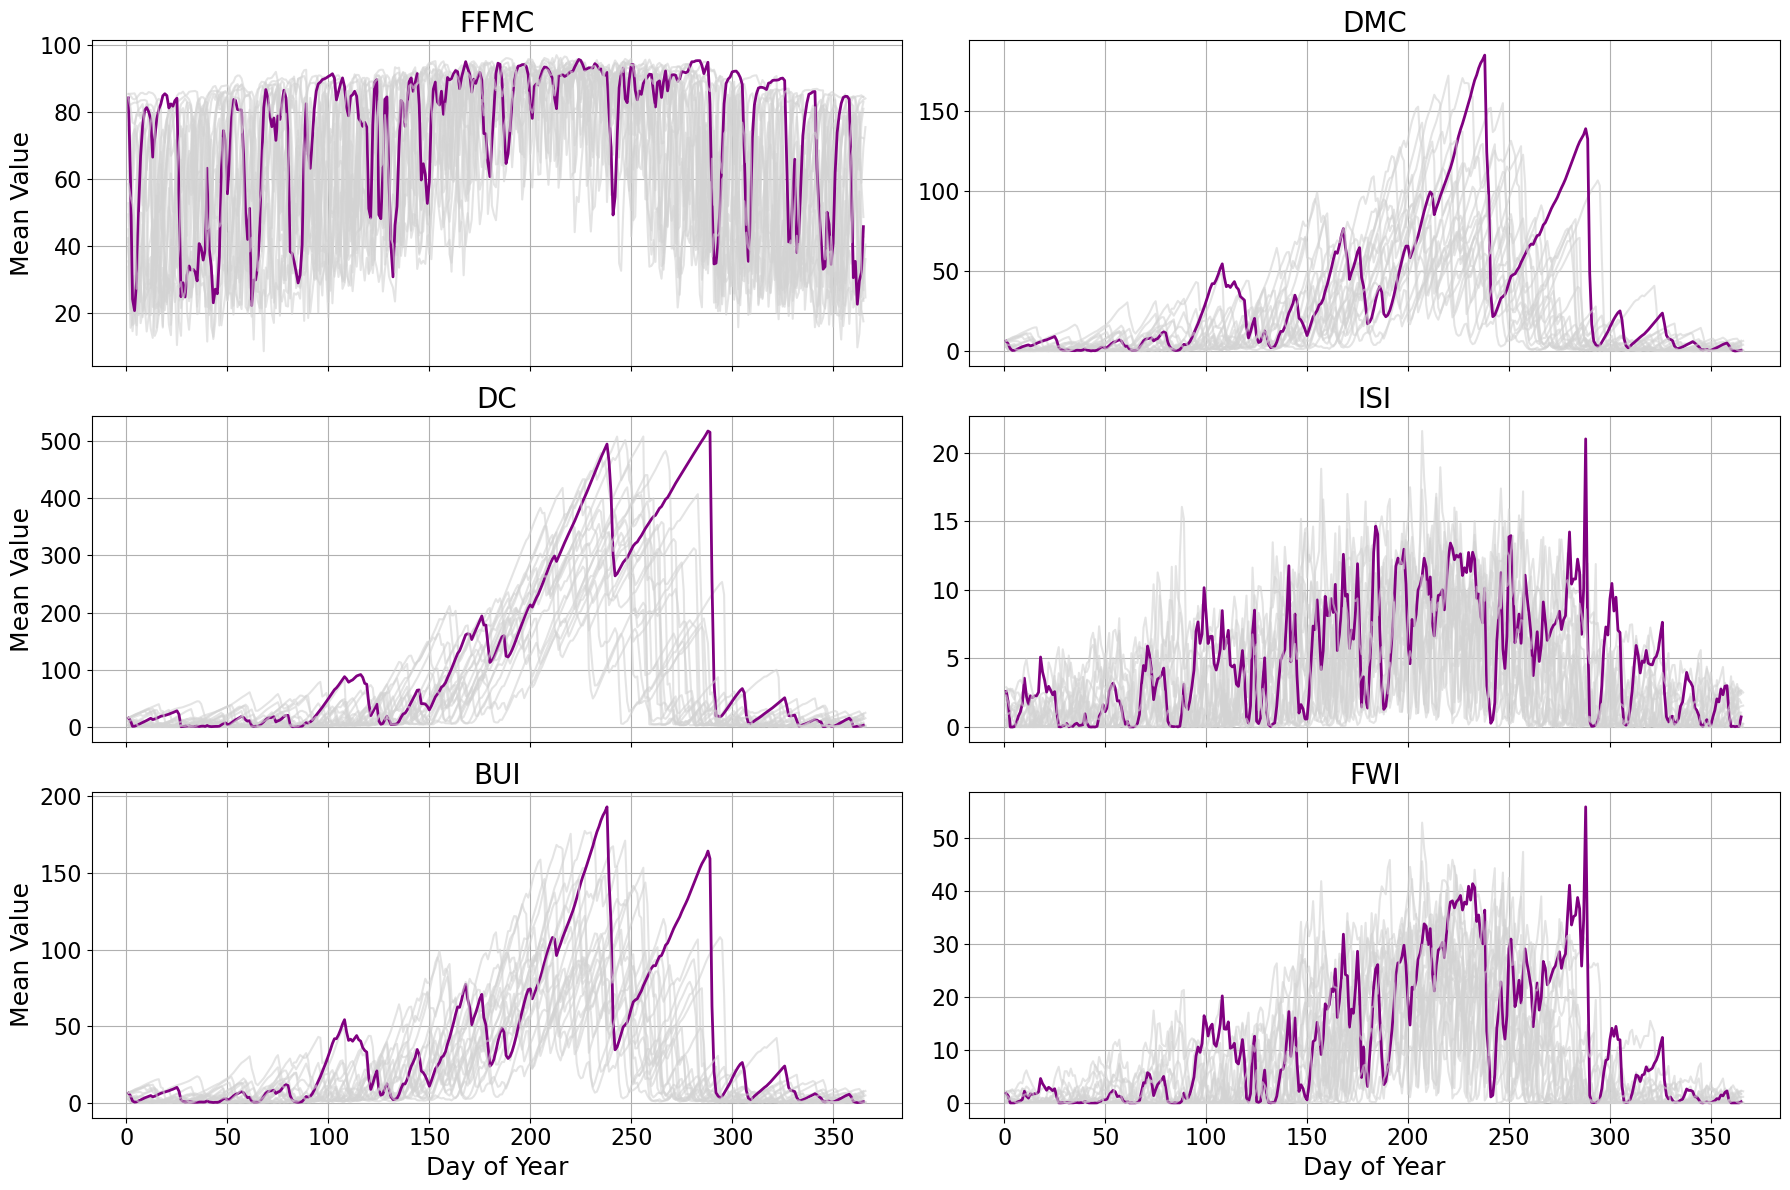

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Get the number of columns
ncols = 2  

# Loop through each variable and plot
for i, var in enumerate(variables):
    ax = axes[i]
    
    # Group by year and plot each year as a separate line
    for year, group in mean_data.groupby("year"):
        if year == 2017:
            ax.plot(group["doy"], group[var], color="purple", linewidth=2)
        else:
            ax.plot(group["doy"], group[var], color="lightgrey", alpha=0.6)
    
    # Set title
    ax.set_title(var.upper(), fontsize=20)
    
    # Only add x-axis label for the bottom row
    if i >= len(axes) - ncols:
        ax.set_xlabel("Day of Year", fontsize=18)
    
    # Only add y-axis label for the leftmost column
    if i % ncols == 0:
        ax.set_ylabel("Mean Value", fontsize=18)
    
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True)

# Adjust layout
plt.tight_layout()

plt.savefig(path_fig + 'FWI_variables_timeseries.png', bbox_inches = 'tight', dpi = 250)